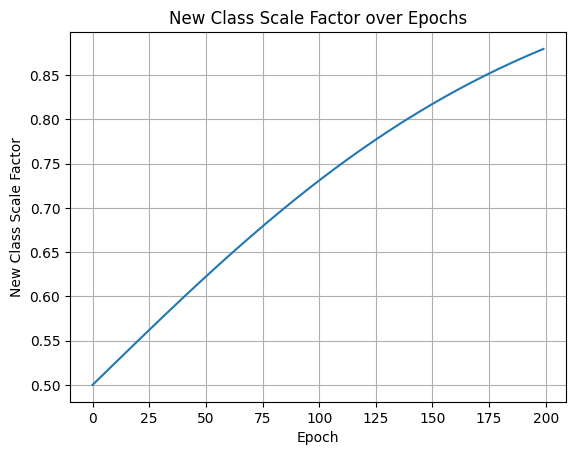

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def compute_scale_factor(epoch):
    sigmoid_shift = epoch / 100  # 100是您提到的轮次，可以根据实际情况调整
    return 1 / (1 + np.exp(-sigmoid_shift))

# 定义一个范围的epoch
epochs = np.arange(0, 200)  # 假设总共有200轮

# 计算每个epoch对应的放大系数
scale_factors = [compute_scale_factor(epoch) for epoch in epochs]

# 绘制曲线
plt.plot(epochs, scale_factors)
plt.xlabel('Epoch')
plt.ylabel('New Class Scale Factor')
plt.title('New Class Scale Factor over Epochs')
plt.grid(True)
plt.show()


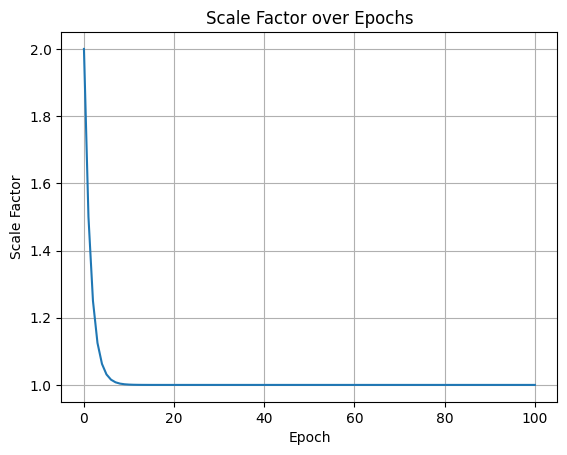

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def scale_factor(epoch):
    return (0.5)**epoch +1

# 定义一个范围的epoch
epochs = np.arange(0, 101)  # epoch范围是0-100

# 计算每个epoch对应的放大系数
scale_factors = [scale_factor(epoch) for epoch in epochs]

# 绘制曲线
plt.plot(epochs, scale_factors)
plt.xlabel('Epoch')
plt.ylabel('Scale Factor')
plt.title('Scale Factor over Epochs')
plt.grid(True)
plt.show()


In [8]:
# 聚类测试
# 模型
import torch
import torch.nn as nn
import torch.nn.functional as F
class DINOHead(nn.Module):
    def __init__(self, in_dim, out_dim, use_bn=False, norm_last_layer=True, 
                 nlayers=3, hidden_dim=2048, bottleneck_dim=256):
        super().__init__()
        nlayers = max(nlayers, 1)
        if nlayers == 1:
            self.mlp = nn.Linear(in_dim, bottleneck_dim)
        elif nlayers != 0:
            layers = [nn.Linear(in_dim, hidden_dim)]
            if use_bn:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.GELU())
            for _ in range(nlayers - 2):
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                if use_bn:
                    layers.append(nn.BatchNorm1d(hidden_dim))
                layers.append(nn.GELU())
            layers.append(nn.Linear(hidden_dim, bottleneck_dim))
            self.mlp = nn.Sequential(*layers)
        self.apply(self._init_weights)
        self.last_layer = nn.utils.weight_norm(nn.Linear(in_dim, out_dim, bias=False))
        self.last_layer.weight_g.data.fill_(1)
        if norm_last_layer:
            self.last_layer.weight_g.requires_grad = False

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x_proj = self.mlp(x)
        x = nn.functional.normalize(x, dim=-1, p=2)
        # x = x.detach()
        logits = self.last_layer(x)
        return x_proj, logits
    
backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16')
projector = DINOHead(in_dim=768, out_dim=200, nlayers=3)
checkpoint = torch.load('/wang_hp/zhy/SimGCD-main/dev_outputs/simgcd/log/init_test_(04.09.2023_|_50.012)/checkpoints/model.pt', map_location='cuda')
model = nn.Sequential(backbone, projector).to('cuda')
model.load_state_dict(checkpoint['model'])

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


<All keys matched successfully>

In [2]:
# 数据集
import sys
sys.path.append('/wang_hp/zhy/SimGCD-main')
from data.cub import get_cub_datasets
from data.data_utils import MergedDataset
from torchvision import transforms
from copy import deepcopy

image_size = 224
interpolation = 3
crop_pct = 0.875
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
test_transform = transforms.Compose([
            transforms.Resize(int(image_size / crop_pct), interpolation),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=torch.tensor(mean),
                std=torch.tensor(std))
        ])

get_dataset_funcs = {
    'cub': get_cub_datasets,
}

def get_datasets(dataset_name, train_transform, test_transform, args):

    """
    :return: train_dataset: MergedDataset which concatenates labelled and unlabelled
             test_dataset,
             unlabelled_train_examples_test,
             datasets
    """

    #
    if dataset_name not in get_dataset_funcs.keys():
        raise ValueError

    # Get datasets
    get_dataset_f = get_dataset_funcs[dataset_name]
    datasets = get_dataset_f(train_transform=train_transform, test_transform=test_transform,
                            train_classes=args.train_classes,
                            prop_train_labels=args.prop_train_labels,
                            split_train_val=False)
    # Set target transforms:
    target_transform_dict = {}
    for i, cls in enumerate(list(args.train_classes) + list(args.unlabeled_classes)):
        target_transform_dict[cls] = i
    target_transform = lambda x: target_transform_dict[x]

    for dataset_name, dataset in datasets.items():
        if dataset is not None:
            dataset.target_transform = target_transform

    # Train split (labelled and unlabelled classes) for training
    train_dataset = MergedDataset(labelled_dataset=deepcopy(datasets['train_labelled']),
                                  unlabelled_dataset=deepcopy(datasets['train_unlabelled']))

    test_dataset = datasets['test']
    unlabelled_train_examples_test = deepcopy(datasets['train_unlabelled'])
    unlabelled_train_examples_test.transform = test_transform

    return train_dataset, test_dataset, unlabelled_train_examples_test, datasets

/root/miniconda3/envs/gcd/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [3]:
import argparse
from torch.utils.data import DataLoader
parser = argparse.ArgumentParser(description='cluster', formatter_class=argparse.ArgumentDefaultsHelpFormatter)
args, unknown = parser.parse_known_args()
args.dataset_name='cub'
args.train_classes = range(100)
args.unlabeled_classes = range(100, 200)
args.prop_train_labels=0.5
_, _, unlabelled_train_examples_test, _ = get_datasets(args.dataset_name,None,test_transform,args)

Files already downloaded and verified


In [4]:
len(unlabelled_train_examples_test)

4494

In [5]:
test_loader_unlabelled = DataLoader(unlabelled_train_examples_test, num_workers=8,batch_size=256, shuffle=False, pin_memory=False)

In [9]:
import numpy as np
projs = []
logits = []
labels = []
mask = np.array([])
model.eval()
for batch_idx, (images, label, _) in enumerate(test_loader_unlabelled):
    images = images.cuda()
    with torch.no_grad():
        proj, logit = model(images)
        projs.append(proj)
        logits.append(logit)
        labels.append(label)
        mask = np.append(mask, np.array([True if x.item() in range(len(args.train_classes)) else False for x in label]))

In [10]:
from scipy.optimize import linear_sum_assignment as linear_assignment
import torch.distributed as dist

def all_sum_item(item):
    item = torch.tensor(item).cuda()
    dist.all_reduce(item)
    return item.item()

def split_cluster_acc_v2(y_true, y_pred, mask):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    First compute linear assignment on all data, then look at how good the accuracy is on subsets

    # Arguments
        mask: Which instances come from old classes (True) and which ones come from new classes (False)
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(int)

    old_classes_gt = set(y_true[mask])
    new_classes_gt = set(y_true[~mask])

    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=int)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    ind = linear_assignment(w.max() - w)
    ind = np.vstack(ind).T

    ind_map = {j: i for i, j in ind}
    total_acc = sum([w[i, j] for i, j in ind])
    total_instances = y_pred.size
    try: 
        if dist.get_world_size() > 0:
            total_acc = all_sum_item(total_acc)
            total_instances = all_sum_item(total_instances)
    except:
        pass
    total_acc /= total_instances

    old_acc = 0
    total_old_instances = 0
    for i in old_classes_gt:
        old_acc += w[ind_map[i], i]
        total_old_instances += sum(w[:, i])
    
    try:
        if dist.get_world_size() > 0:
            old_acc = all_sum_item(old_acc)
            total_old_instances = all_sum_item(total_old_instances)
    except:
        pass
    old_acc /= total_old_instances

    new_acc = 0
    total_new_instances = 0
    for i in new_classes_gt:
        new_acc += w[ind_map[i], i]
        total_new_instances += sum(w[:, i])
    
    try:
        if dist.get_world_size() > 0:
            new_acc = all_sum_item(new_acc)
            total_new_instances = all_sum_item(total_new_instances)
    except:
        pass
    new_acc /= total_new_instances

    return total_acc, old_acc, new_acc

In [11]:
import numpy as np
# 使用torch.cat()合并tensors
projs_tensor = torch.cat(projs, dim=0)
logits_tensor = torch.cat(logits, dim=0)
labels_tensor = torch.cat(labels, dim=0)

# 将tensors转换为numpy数组
projs_np = projs_tensor.cpu().numpy()
logits_np = logits_tensor.cpu().numpy()
labels_np = labels_tensor.cpu().numpy()
projs_np.shape, logits_np.shape, labels_np.shape

((4494, 256), (4494, 200), (4494,))

In [13]:
# 使用kmeans聚类
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
n_clusters = len(np.unique(labels_np))  # 获取类别的数量
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(projs_np)
predicted_labels = kmeans.labels_
# from scipy.stats import mode

# def relabel_clusters(true_labels, predicted_labels):
#     relabeled = np.zeros_like(predicted_labels)
#     for i in range(n_clusters):
#         mask = (predicted_labels == i)
#         relabeled[mask] = mode(true_labels[mask])[0]
#     return relabeled

# relabelled_preds = relabel_clusters(labels_np, predicted_labels)
# accuracy = accuracy_score(labels_np, relabelled_preds)
mask = mask.astype(bool)
total_acc, old_acc, new_acc = split_cluster_acc_v2(labels_np, predicted_labels, mask)

/root/miniconda3/envs/gcd/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [14]:
total_acc, old_acc, new_acc

(0.562082777036048, 0.7333333333333333, 0.47628590514362057)

In [32]:
# TSNE降维
from sklearn.manifold import TSNE

# 使用TSNE降维
tsne = TSNE(n_components=3, random_state=42, n_iter=5000, perplexity=40)  # 设置随机种子以确保结果的可重复性
projs_np_tsne_20d = tsne.fit_transform(projs_np)

# 检查降维后的形状
print(projs_np_tsne_20d.shape)


(4494, 3)


In [33]:
# TSNE降维后使用kmeans聚类
# 使用kmeans聚类
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
n_clusters = len(np.unique(labels_np))  # 获取类别的数量
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(projs_np_tsne_20d)
predicted_labels = kmeans.labels_
# from scipy.stats import mode

# def relabel_clusters(true_labels, predicted_labels):
#     relabeled = np.zeros_like(predicted_labels)
#     for i in range(n_clusters):
#         mask = (predicted_labels == i)
#         relabeled[mask] = mode(true_labels[mask])[0]
#     return relabeled

# relabelled_preds = relabel_clusters(labels_np, predicted_labels)
# accuracy = accuracy_score(labels_np, relabelled_preds)
mask = mask.astype(bool)
total_acc, old_acc, new_acc = split_cluster_acc_v2(labels_np, predicted_labels, mask)
print(total_acc, old_acc, new_acc)

/root/miniconda3/envs/gcd/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.584334668446818 0.7273333333333334 0.5126920507682031


In [28]:
# 主成分分析降维
from sklearn.decomposition import PCA

# 使用PCA降维
pca = PCA(n_components=10)
projs_np_pca_20d = pca.fit_transform(projs_np)

# 检查降维后的形状
print(projs_np_pca_20d.shape)

(4494, 10)


In [29]:
# 主成分分析降维后使用kmeans聚类
# 使用kmeans聚类
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
n_clusters = len(np.unique(labels_np))  # 获取类别的数量
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(projs_np_pca_20d)
predicted_labels = kmeans.labels_
# from scipy.stats import mode

# def relabel_clusters(true_labels, predicted_labels):
#     relabeled = np.zeros_like(predicted_labels)
#     for i in range(n_clusters):
#         mask = (predicted_labels == i)
#         relabeled[mask] = mode(true_labels[mask])[0]
#     return relabeled

# relabelled_preds = relabel_clusters(labels_np, predicted_labels)
# accuracy = accuracy_score(labels_np, relabelled_preds)
mask = mask.astype(bool)
total_acc, old_acc, new_acc = split_cluster_acc_v2(labels_np, predicted_labels, mask)
print(total_acc, old_acc, new_acc)

/root/miniconda3/envs/gcd/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.285491766800178 0.15266666666666667 0.3520374081496326


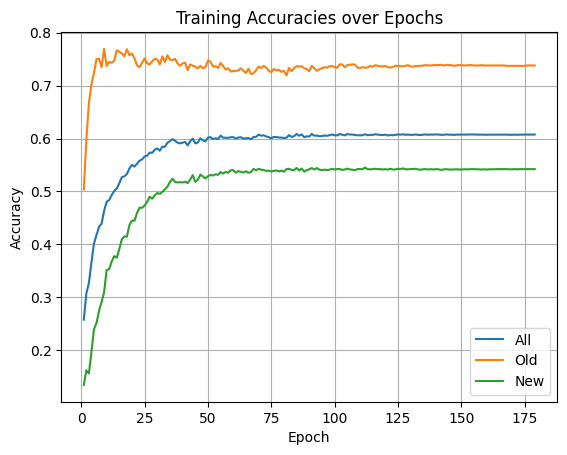

In [1]:
import re
import matplotlib.pyplot as plt

# 从log.txt中读取数据
with open('/wang_hp/zhy/SimGCD-main/dev_outputs/simgcd/log/init_test_(04.09.2023_|_50.012)/log.txt', 'r') as f:
    lines = f.readlines()

# 使用正则表达式提取精度值
pattern = r"Train Accuracies: All (\d+\.\d+) \| Old (\d+\.\d+) \| New (\d+\.\d+)"
all_accuracies = []
old_accuracies = []
new_accuracies = []

for line in lines:
    match = re.search(pattern, line)
    if match:
        all_accuracies.append(float(match.group(1)))
        old_accuracies.append(float(match.group(2)))
        new_accuracies.append(float(match.group(3)))

# 绘制曲线图
epochs = list(range(1, len(all_accuracies) + 1))
plt.plot(epochs, all_accuracies, label='All')
plt.plot(epochs, old_accuracies, label='Old')
plt.plot(epochs, new_accuracies, label='New')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracies over Epochs')
plt.legend()
plt.grid(True)
plt.show()


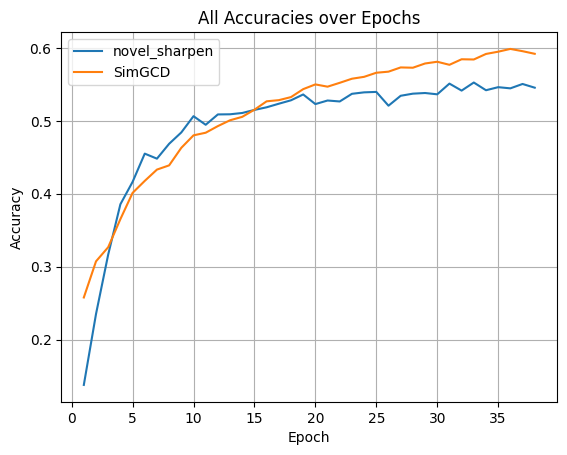

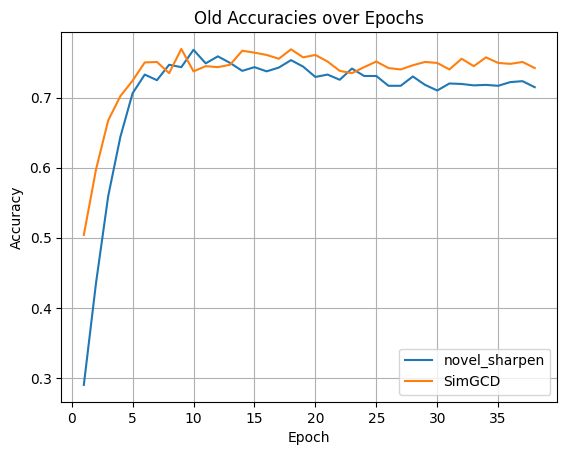

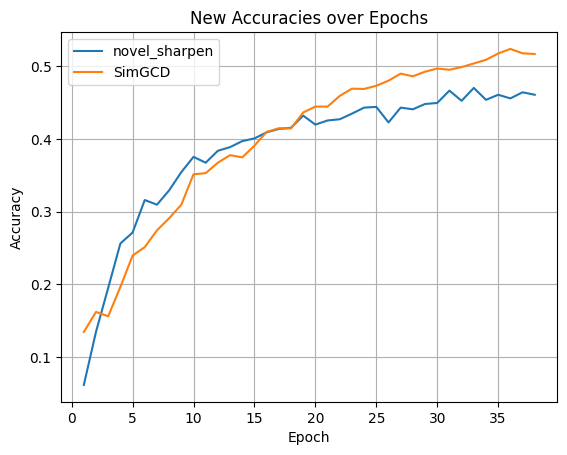

In [2]:
import re
import matplotlib.pyplot as plt

def extract_accuracies_from_log(filename):
    # 从文件中读取数据
    with open(filename, 'r') as f:
        lines = f.readlines()

    # 使用正则表达式提取精度值
    pattern = r"Train Accuracies: All (\d+\.\d+) \| Old (\d+\.\d+) \| New (\d+\.\d+)"
    all_accuracies = []
    old_accuracies = []
    new_accuracies = []

    for line in lines:
        match = re.search(pattern, line)
        if match:
            all_accuracies.append(float(match.group(1)))
            old_accuracies.append(float(match.group(2)))
            new_accuracies.append(float(match.group(3)))

    return all_accuracies, old_accuracies, new_accuracies

# 从两个日志文件中提取精度值
all_accuracies1, old_accuracies1, new_accuracies1 = extract_accuracies_from_log('/wang_hp/zhy/SimGCD-main/dev_outputs/simgcd/log/novel_sharpen_test1_(05.09.2023_|_06.601)/log.txt')
all_accuracies2, old_accuracies2, new_accuracies2 = extract_accuracies_from_log('/wang_hp/zhy/SimGCD-main/dev_outputs/simgcd/log/init_test_(04.09.2023_|_50.012)/log.txt')

# 获取最小的epoch数
min_epochs = min(len(all_accuracies1), len(all_accuracies2))

# 绘制三个图
def plot_accuracies(accuracies1, accuracies2, title):
    epochs = list(range(1, min_epochs + 1))
    plt.plot(epochs, accuracies1[:min_epochs], label='novel_sharpen')
    plt.plot(epochs, accuracies2[:min_epochs], label='SimGCD')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracies(all_accuracies1, all_accuracies2, 'All Accuracies over Epochs')
plot_accuracies(old_accuracies1, old_accuracies2, 'Old Accuracies over Epochs')
plot_accuracies(new_accuracies1, new_accuracies2, 'New Accuracies over Epochs')


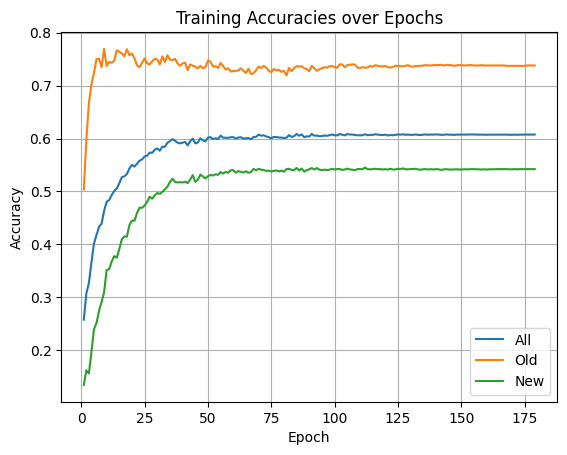

In [2]:
#SimGCD
import re
import matplotlib.pyplot as plt

# 从log.txt中读取数据
with open('/wang_hp/zhy/SimGCD-main/dev_outputs/simgcd/log/init_test_(04.09.2023_|_50.012)/log.txt', 'r') as f:
    lines = f.readlines()

# 使用正则表达式提取精度值
pattern = r"Train Accuracies: All (\d+\.\d+) \| Old (\d+\.\d+) \| New (\d+\.\d+)"
all_accuracies = []
old_accuracies = []
new_accuracies = []

for line in lines:
    match = re.search(pattern, line)
    if match:
        all_accuracies.append(float(match.group(1)))
        old_accuracies.append(float(match.group(2)))
        new_accuracies.append(float(match.group(3)))

# 绘制曲线图
epochs = list(range(1, len(all_accuracies) + 1))
plt.plot(epochs, all_accuracies, label='All')
plt.plot(epochs, old_accuracies, label='Old')
plt.plot(epochs, new_accuracies, label='New')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracies over Epochs')
plt.legend()
plt.grid(True)
plt.show()


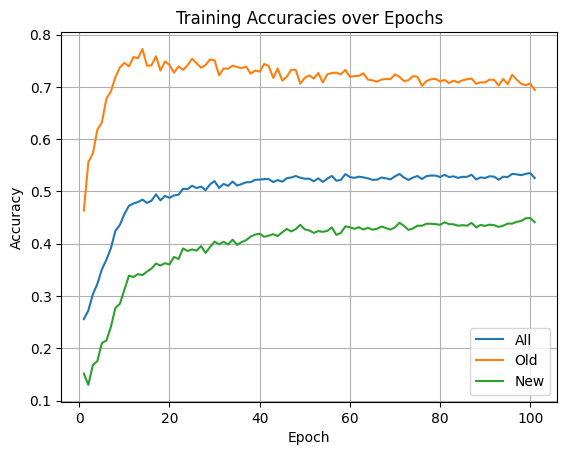

In [3]:
# top5 1.0
import re
import matplotlib.pyplot as plt

# 从log.txt中读取数据
with open('/wang_hp/zhy/SimGCD-main/dev_outputs/simgcd/log/top5_test_(08.09.2023_|_59.182)/log.txt', 'r') as f:
    lines = f.readlines()

# 使用正则表达式提取精度值
pattern = r"Train Accuracies: All (\d+\.\d+) \| Old (\d+\.\d+) \| New (\d+\.\d+)"
all_accuracies = []
old_accuracies = []
new_accuracies = []

for line in lines:
    match = re.search(pattern, line)
    if match:
        all_accuracies.append(float(match.group(1)))
        old_accuracies.append(float(match.group(2)))
        new_accuracies.append(float(match.group(3)))

# 绘制曲线图
epochs = list(range(1, len(all_accuracies) + 1))
plt.plot(epochs, all_accuracies, label='All')
plt.plot(epochs, old_accuracies, label='Old')
plt.plot(epochs, new_accuracies, label='New')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracies over Epochs')
plt.legend()
plt.grid(True)
plt.show()


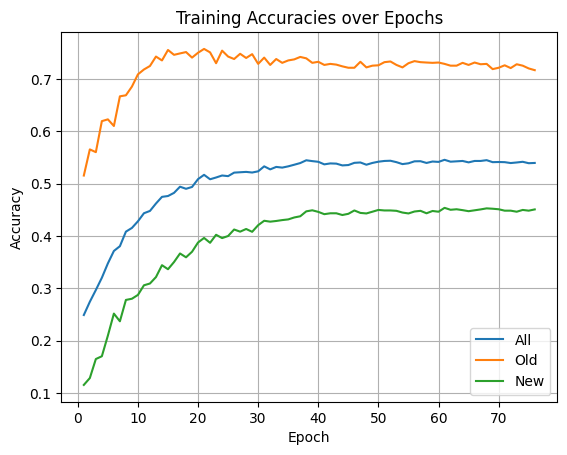

In [6]:
# top5 2.0
import re
import matplotlib.pyplot as plt

# 从log.txt中读取数据
with open('/wang_hp/zhy/SimGCD-main/dev_outputs/simgcd/log/top5_test_(08.09.2023_|_43.721)/log.txt', 'r') as f:
    lines = f.readlines()

# 使用正则表达式提取精度值
pattern = r"Train Accuracies: All (\d+\.\d+) \| Old (\d+\.\d+) \| New (\d+\.\d+)"
all_accuracies = []
old_accuracies = []
new_accuracies = []

for line in lines:
    match = re.search(pattern, line)
    if match:
        all_accuracies.append(float(match.group(1)))
        old_accuracies.append(float(match.group(2)))
        new_accuracies.append(float(match.group(3)))

# 绘制曲线图
epochs = list(range(1, len(all_accuracies) + 1))
plt.plot(epochs, all_accuracies, label='All')
plt.plot(epochs, old_accuracies, label='Old')
plt.plot(epochs, new_accuracies, label='New')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracies over Epochs')
plt.legend()
plt.grid(True)
plt.show()


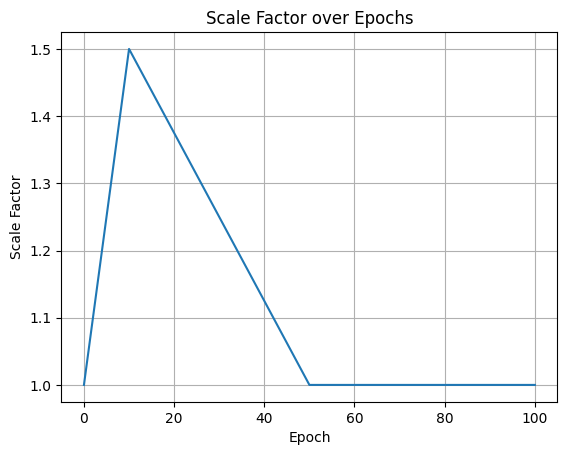

In [16]:
# 新类别强化实验
import numpy as np
import matplotlib.pyplot as plt

def scale_factor(epoch):
    return (0.5)**epoch +1

# 定义一个范围的epoch
epochs = np.arange(0, 101)  # epoch范围是0-100

# 计算每个epoch对应的放大系数
scale_factors = [scale_factor(epoch) for epoch in epochs]
# 先升后降-线性
def compute_value(epoch):
    if 0 <= epoch <= 10:
        return 1 + 0.05 * epoch
    elif 10 < epoch <= 50:
        return 1.5 - 0.0125 * (epoch - 10)
    elif epoch > 50:
        return 1
    else:
        raise ValueError("Epoch value out of range!")
linear_factors = [compute_value(epoch) for epoch in epochs]    
# 绘制曲线
plt.plot(epochs, linear_factors)
plt.xlabel('Epoch')
plt.ylabel('Scale Factor')
plt.title('Scale Factor over Epochs')
plt.grid(True)
plt.show()

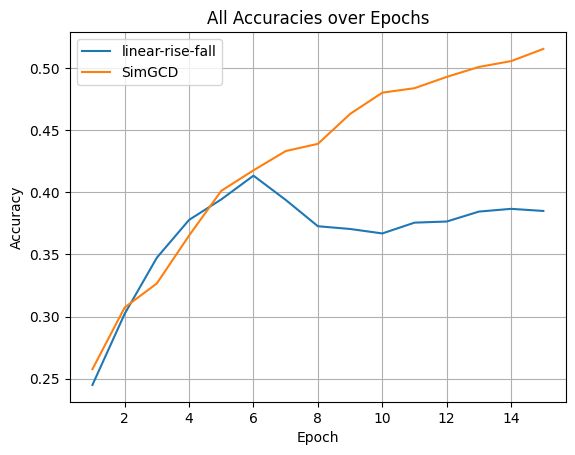

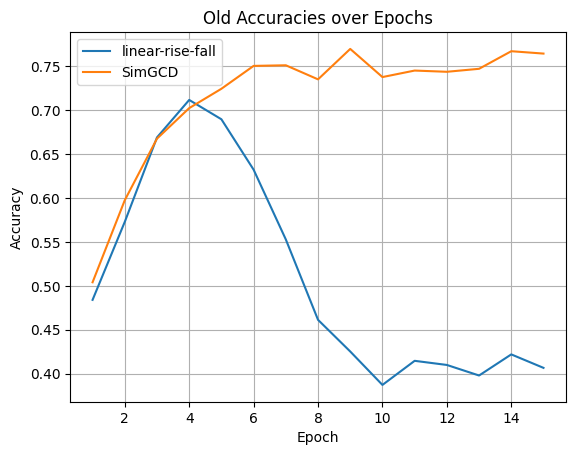

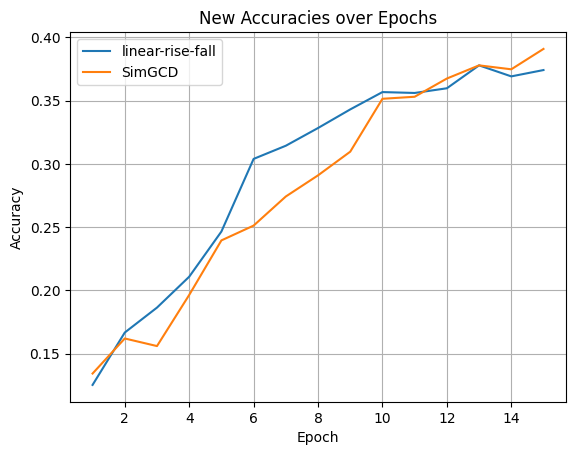

In [10]:
import re
import matplotlib.pyplot as plt

def extract_accuracies_from_log(filename):
    # 从文件中读取数据
    with open(filename, 'r') as f:
        lines = f.readlines()

    # 使用正则表达式提取精度值
    pattern = r"Train Accuracies: All (\d+\.\d+) \| Old (\d+\.\d+) \| New (\d+\.\d+)"
    all_accuracies = []
    old_accuracies = []
    new_accuracies = []

    for line in lines:
        match = re.search(pattern, line)
        if match:
            all_accuracies.append(float(match.group(1)))
            old_accuracies.append(float(match.group(2)))
            new_accuracies.append(float(match.group(3)))

    return all_accuracies, old_accuracies, new_accuracies

# 从两个日志文件中提取精度值
all_accuracies1, old_accuracies1, new_accuracies1 = extract_accuracies_from_log('/wang_hp/zhy/SimGCD-main/dev_outputs/simgcd/log/linear-rise-fall_(09.09.2023_|_55.052)/log.txt')
all_accuracies2, old_accuracies2, new_accuracies2 = extract_accuracies_from_log('/wang_hp/zhy/SimGCD-main/dev_outputs/simgcd/log/init_test_(04.09.2023_|_50.012)/log.txt')

# 获取最小的epoch数
min_epochs = min(len(all_accuracies1), len(all_accuracies2))

# 绘制三个图
def plot_accuracies(accuracies1, accuracies2, title):
    epochs = list(range(1, min_epochs + 1))
    plt.plot(epochs, accuracies1[:min_epochs], label='linear-rise-fall')
    plt.plot(epochs, accuracies2[:min_epochs], label='SimGCD')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracies(all_accuracies1, all_accuracies2, 'All Accuracies over Epochs')
plot_accuracies(old_accuracies1, old_accuracies2, 'Old Accuracies over Epochs')
plot_accuracies(new_accuracies1, new_accuracies2, 'New Accuracies over Epochs')


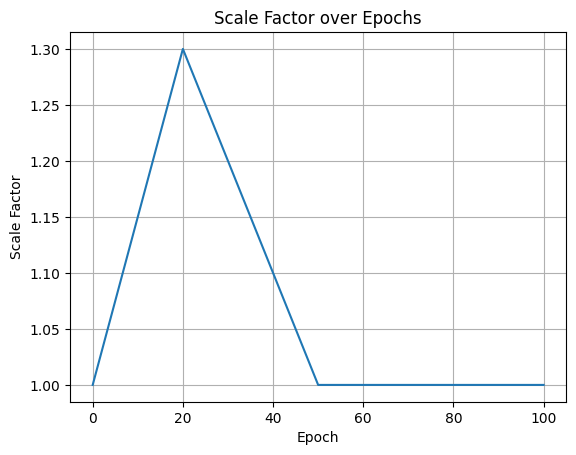

In [18]:
# 新类别强化实验
#linear-rise-fall-2
import numpy as np
import matplotlib.pyplot as plt

def scale_factor(epoch):
    return (0.5)**epoch +1

# 定义一个范围的epoch
epochs = np.arange(0, 101)  # epoch范围是0-100

# 计算每个epoch对应的放大系数
scale_factors = [scale_factor(epoch) for epoch in epochs]
# 先升后降-线性
def compute_value(epoch):
    if 0 <= epoch <= 20:
        return 1 + 0.015 * epoch
    elif 20 < epoch <= 50:
        return 1.3 - 0.01 * (epoch - 20)
    elif epoch > 50:
        return 1
    else:
        raise ValueError("Epoch value out of range!")

linear_factors = [compute_value(epoch) for epoch in epochs]    
# 绘制曲线
plt.plot(epochs, linear_factors)
plt.xlabel('Epoch')
plt.ylabel('Scale Factor')
plt.title('Scale Factor over Epochs')
plt.grid(True)
plt.show()

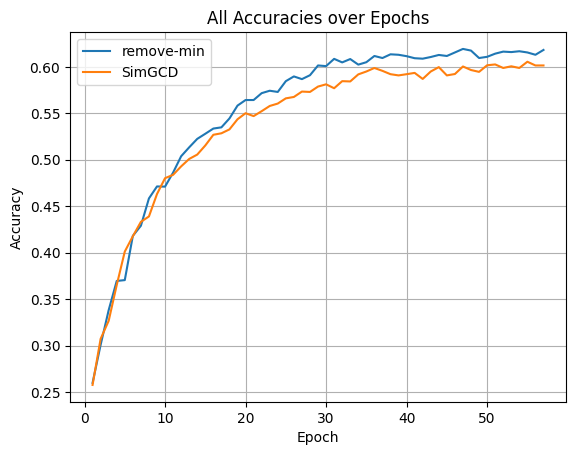

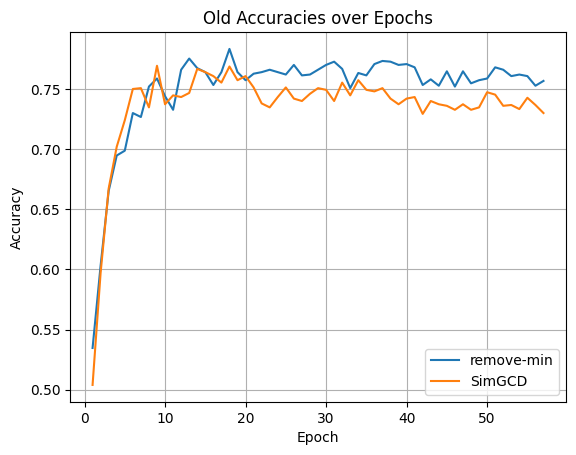

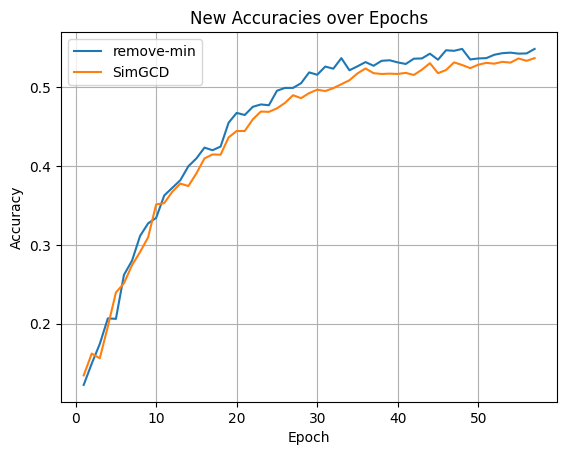

In [25]:
import re
import matplotlib.pyplot as plt

def extract_accuracies_from_log(filename):
    # 从文件中读取数据
    with open(filename, 'r') as f:
        lines = f.readlines()

    # 使用正则表达式提取精度值
    pattern = r"Train Accuracies: All (\d+\.\d+) \| Old (\d+\.\d+) \| New (\d+\.\d+)"
    all_accuracies = []
    old_accuracies = []
    new_accuracies = []

    for line in lines:
        match = re.search(pattern, line)
        if match:
            all_accuracies.append(float(match.group(1)))
            old_accuracies.append(float(match.group(2)))
            new_accuracies.append(float(match.group(3)))

    return all_accuracies, old_accuracies, new_accuracies

# 从两个日志文件中提取精度值
all_accuracies1, old_accuracies1, new_accuracies1 = extract_accuracies_from_log('/wang_hp/zhy/SimGCD-main/dev_outputs/simgcd/log/remove-min_(09.09.2023_|_24.935)/log.txt')
all_accuracies2, old_accuracies2, new_accuracies2 = extract_accuracies_from_log('/wang_hp/zhy/SimGCD-main/dev_outputs/simgcd/log/init_test_(04.09.2023_|_50.012)/log.txt')

# 获取最小的epoch数
min_epochs = min(len(all_accuracies1), len(all_accuracies2))

# 绘制三个图
def plot_accuracies(accuracies1, accuracies2, title):
    epochs = list(range(1, min_epochs + 1))
    plt.plot(epochs, accuracies1[:min_epochs], label='remove-min')
    plt.plot(epochs, accuracies2[:min_epochs], label='SimGCD')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracies(all_accuracies1, all_accuracies2, 'All Accuracies over Epochs')
plot_accuracies(old_accuracies1, old_accuracies2, 'Old Accuracies over Epochs')
plot_accuracies(new_accuracies1, new_accuracies2, 'New Accuracies over Epochs')


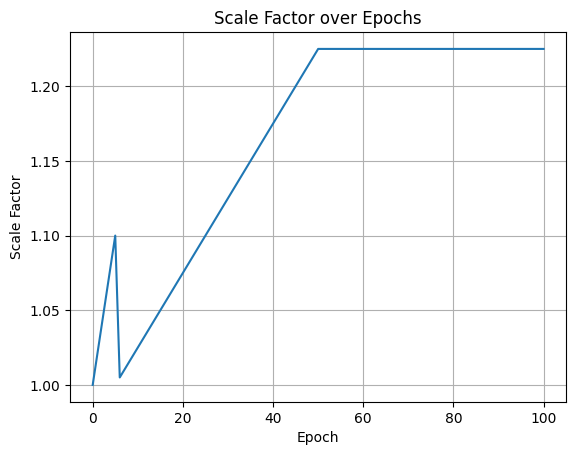

In [29]:
# 新类别强化实验
#linear-rise-rise
import numpy as np
import matplotlib.pyplot as plt

def scale_factor(epoch):
    return (0.5)**epoch +1

# 定义一个范围的epoch
epochs = np.arange(0, 101)  # epoch范围是0-100

# 计算每个epoch对应的放大系数
scale_factors = [scale_factor(epoch) for epoch in epochs]
# 先升后降-线性
def compute_value(epoch):
    if 0 <= epoch <= 5:
        return 1 + 0.02 * epoch
    elif 5 < epoch <= 50:
        return 1+0.005 * (epoch-5)
    elif epoch > 50:
        return 1+0.005 * (50-5)
    else:
        raise ValueError("Epoch value out of range!")

linear_factors = [compute_value(epoch) for epoch in epochs]    
# 绘制曲线
plt.plot(epochs, linear_factors)
plt.xlabel('Epoch')
plt.ylabel('Scale Factor')
plt.title('Scale Factor over Epochs')
plt.grid(True)
plt.show()

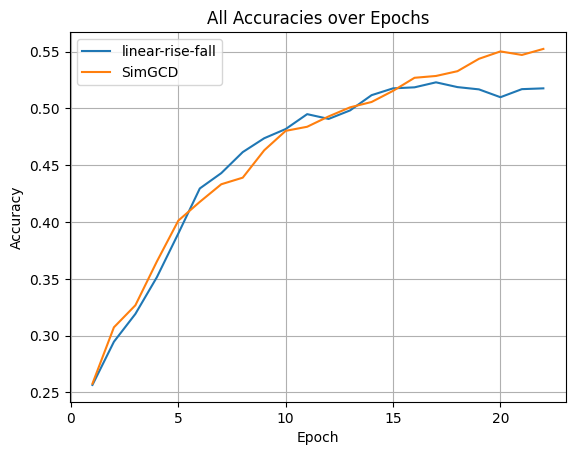

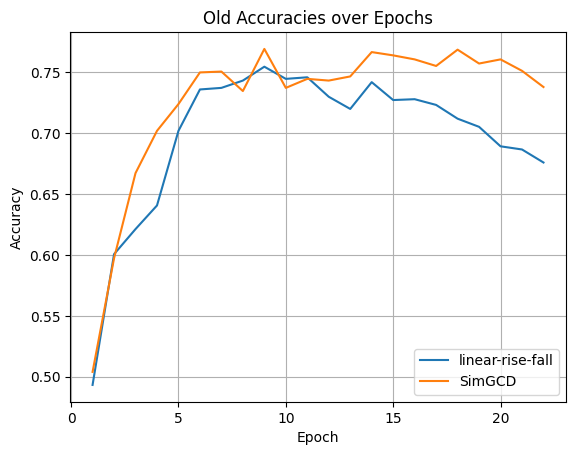

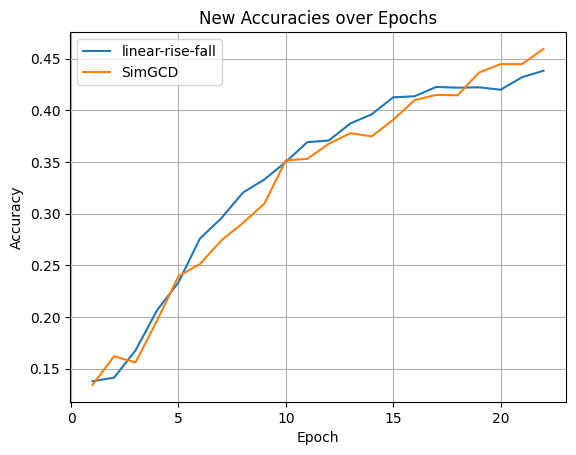

In [31]:
import re
import matplotlib.pyplot as plt

def extract_accuracies_from_log(filename):
    # 从文件中读取数据
    with open(filename, 'r') as f:
        lines = f.readlines()

    # 使用正则表达式提取精度值
    pattern = r"Train Accuracies: All (\d+\.\d+) \| Old (\d+\.\d+) \| New (\d+\.\d+)"
    all_accuracies = []
    old_accuracies = []
    new_accuracies = []

    for line in lines:
        match = re.search(pattern, line)
        if match:
            all_accuracies.append(float(match.group(1)))
            old_accuracies.append(float(match.group(2)))
            new_accuracies.append(float(match.group(3)))

    return all_accuracies, old_accuracies, new_accuracies

# 从两个日志文件中提取精度值
all_accuracies1, old_accuracies1, new_accuracies1 = extract_accuracies_from_log('/wang_hp/zhy/SimGCD-main/dev_outputs/simgcd/log/linear-rise-rise_(09.09.2023_|_20.208)/log.txt')
all_accuracies2, old_accuracies2, new_accuracies2 = extract_accuracies_from_log('/wang_hp/zhy/SimGCD-main/dev_outputs/simgcd/log/init_test_(04.09.2023_|_50.012)/log.txt')

# 获取最小的epoch数
min_epochs = min(len(all_accuracies1), len(all_accuracies2))

# 绘制三个图
def plot_accuracies(accuracies1, accuracies2, title):
    epochs = list(range(1, min_epochs + 1))
    plt.plot(epochs, accuracies1[:min_epochs], label='linear-rise-fall')
    plt.plot(epochs, accuracies2[:min_epochs], label='SimGCD')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracies(all_accuracies1, all_accuracies2, 'All Accuracies over Epochs')
plot_accuracies(old_accuracies1, old_accuracies2, 'Old Accuracies over Epochs')
plot_accuracies(new_accuracies1, new_accuracies2, 'New Accuracies over Epochs')


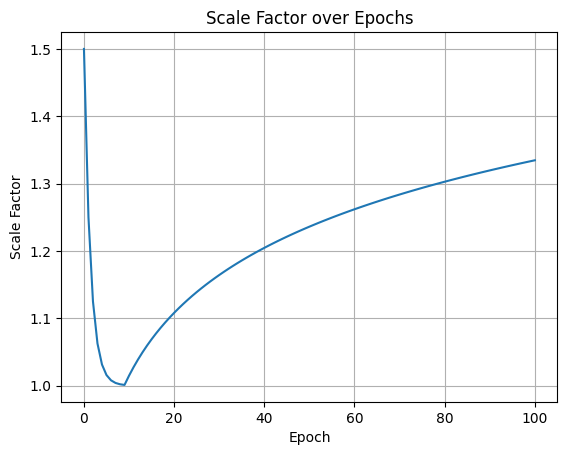

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import math

def scale_factor(epoch):
    if epoch < 10:
        return (0.5)**epoch + 1
    else:
        base_value = (0.5)**10 + 1  # 计算epoch=10时的值
        return base_value+(-0.1*math.log2(10))+0.1*math.log2(epoch)  # 从epoch=10开始应用对数函数

# 定义一个范围的epoch
epochs = np.arange(0, 101)  # epoch范围是0-100

# 计算每个epoch对应的放大系数
scale_factors = [scale_factor(epoch+1) for epoch in epochs]

# 绘制曲线
plt.plot(epochs, scale_factors)
plt.xlabel('Epoch')
plt.ylabel('Scale Factor')
plt.title('Scale Factor over Epochs')
plt.grid(True)
plt.show()

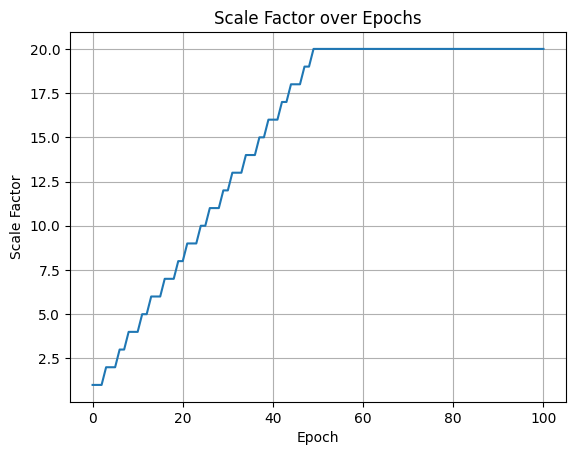

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import math
def replace_values_with_epoch(epoch):
    # epoch = epoch - 25
    # # Determine the number of values to replace based on the epoch
    # if epoch < 0:
    #     num_values_to_replace = 0
    # elif 0<= epoch <=75:
    #     num_values_to_replace = 1 + (epoch * 19) // 49  # Linearly increase from 1 to 20 over 50 epochs
    # else: 
    #     num_values_to_replace = 20  # Keep replacing 20 values for epochs >= 50
    if epoch < 50:
        num_values_to_replace = 1 + (epoch * 19) // 49  # Linearly increase from 1 to 20 over 50 epochs
    else:
        num_values_to_replace = 20

    # if epoch < 70:
    #     num_values_to_replace = 1 + (epoch * 19) // 69  # Linearly increase from 1 to 20 over 70 epochs
    # else:
    #     num_values_to_replace = 20
    return num_values_to_replace

# def replace_values_with_epoch1(epoch):
#     if epoch < 10:
#         num_values_to_replace = 0
#     elif 10 <= epoch < 50:  # 40 epochs to increase from 1 to 20
#         num_values_to_replace = 1 + (epoch - 10) * 19 // 39  # Linearly increase from 1 to 20 over 40 epochs
#     else:
#         num_values_to_replace = 20  # Keep replacing 20 values for epochs >= 50
#     return num_values_to_replace
# def replace_values_with_epoch2(epoch):
#     if epoch < 5:
#         num_values_to_replace = 0
#     elif 5 <= epoch < 50:  # 45 epochs to increase from 1 to 30
#         num_values_to_replace = 1 + (epoch - 5) * 29 // 44  # Linearly increase from 1 to 30 over 45 epochs
#     else:
#         num_values_to_replace = 30  # Keep replacing 30 values for epochs >= 50
#     return num_values_to_replace


# 定义一个范围的epoch
epochs = np.arange(0, 101)  # epoch范围是0-100

# 计算每个epoch对应的放大系数
scale_factors = [replace_values_with_epoch(epoch) for epoch in epochs]

# 绘制曲线
plt.plot(epochs, scale_factors)
plt.xlabel('Epoch')
plt.ylabel('Scale Factor')
plt.title('Scale Factor over Epochs')
plt.grid(True)
plt.show()

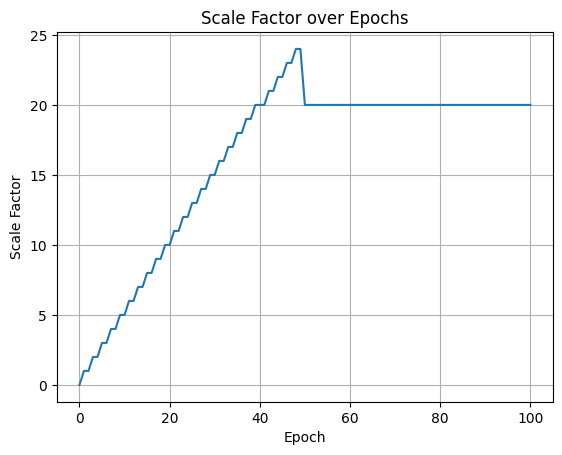

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import math
def replace_values_with_epoch(epoch):
    epoch = epoch
    # Determine the number of values to replace based on the epoch
    # if epoch < 0:
    #     num_values_to_replace = 0
    # elif 0<= epoch <=75:
    #     num_values_to_replace = 1 + (epoch * 19) // 49  # Linearly increase from 1 to 20 over 50 epochs
    # else: 
    #     num_values_to_replace = 20  # Keep replacing 20 values for epochs >= 50
    if epoch == 0:
        num_values_to_replace = 0
    elif 0< epoch < 50:
        num_values_to_replace = 1 + (epoch * 19) // 39  # Linearly increase from 1 to 20 over 70 epochs
    else:
        num_values_to_replace = 20
    return num_values_to_replace

# 定义一个范围的epoch
epochs = np.arange(0, 101) # epoch范围是0-100

# 计算每个epoch对应的放大系数
scale_factors = [replace_values_with_epoch(epoch) for epoch in epochs]

# 绘制曲线
plt.plot(epochs, scale_factors)
plt.xlabel('Epoch')
plt.ylabel('Scale Factor')
plt.title('Scale Factor over Epochs')
plt.grid(True)
plt.show()

[0.2902, 0.324, 0.3525, 0.3705, 0.3983, 0.4072, 0.435, 0.4533, 0.4615, 0.4668, 0.4842, 0.4922, 0.494, 0.5045, 0.5209, 0.5198, 0.5296, 0.5409, 0.547, 0.5541]
[0.58, 0.6267, 0.6793, 0.6987, 0.7253, 0.7327, 0.7433, 0.7327, 0.7433, 0.7547, 0.76, 0.7707, 0.7427, 0.7447, 0.738, 0.7353, 0.738, 0.7513, 0.7407, 0.7553]
[0.145, 0.1723, 0.1887, 0.2061, 0.2345, 0.2442, 0.2806, 0.3133, 0.3203, 0.3226, 0.346, 0.3527, 0.3694, 0.3841, 0.4122, 0.4118, 0.4252, 0.4355, 0.4499, 0.4532]


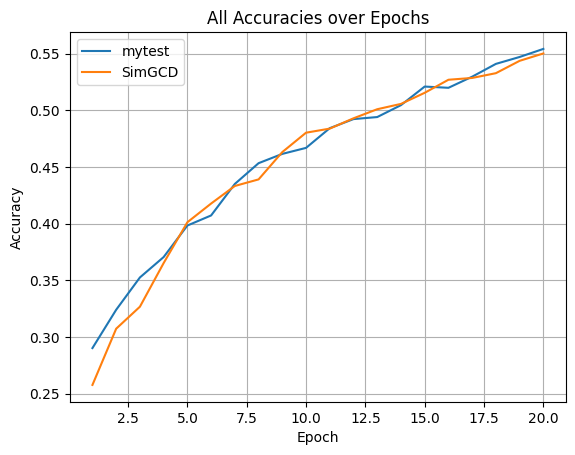

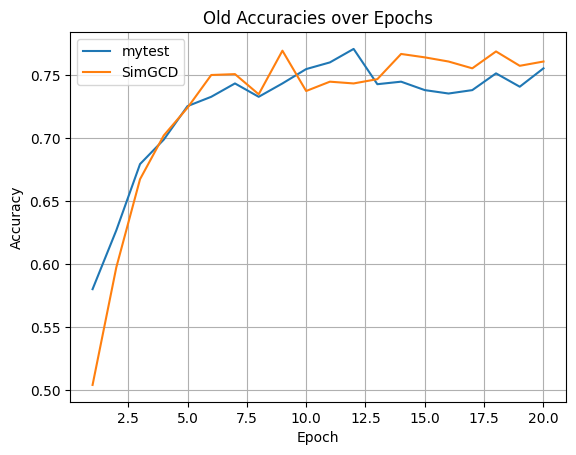

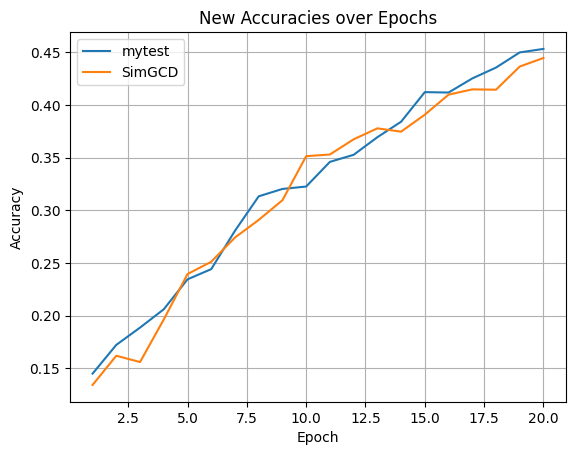

In [45]:
import re
import matplotlib.pyplot as plt

def extract_accuracies_from_log(filename):
    # 从文件中读取数据
    with open(filename, 'r') as f:
        lines = f.readlines()

    # 使用正则表达式提取精度值
    pattern = r"Train Accuracies: All (\d+\.\d+) \| Old (\d+\.\d+) \| New (\d+\.\d+)"
    all_accuracies = []
    old_accuracies = []
    new_accuracies = []

    for line in lines:
        match = re.search(pattern, line)
        if match:
            all_accuracies.append(float(match.group(1)))
            old_accuracies.append(float(match.group(2)))
            new_accuracies.append(float(match.group(3)))

    return all_accuracies, old_accuracies, new_accuracies

# 从两个日志文件中提取精度值
all_accuracies1, old_accuracies1, new_accuracies1 = extract_accuracies_from_log('/wang_hp/zhy/SimGCD-main/dev_outputs/simgcd/log/ghost-tworiseline-simgcdloss_(14.09.2023_|_41.373)/log.txt')
all_accuracies2, old_accuracies2, new_accuracies2 = extract_accuracies_from_log('/wang_hp/zhy/SimGCD-main/dev_outputs/simgcd/log/init_test_(04.09.2023_|_50.012)/log.txt')

print(all_accuracies1)
print(old_accuracies1)
print(new_accuracies1)
# 获取最小的epoch数
min_epochs = min(len(all_accuracies1), len(all_accuracies2))

# 绘制三个图
def plot_accuracies(accuracies1, accuracies2, title):
    epochs = list(range(1, min_epochs + 1))
    plt.plot(epochs, accuracies1[:min_epochs], label='mytest')
    plt.plot(epochs, accuracies2[:min_epochs], label='SimGCD')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracies(all_accuracies1, all_accuracies2, 'All Accuracies over Epochs')
plot_accuracies(old_accuracies1, old_accuracies2, 'Old Accuracies over Epochs')
plot_accuracies(new_accuracies1, new_accuracies2, 'New Accuracies over Epochs')

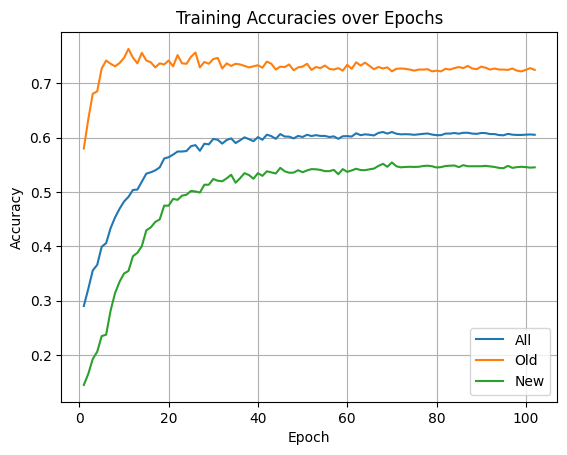

In [38]:
import re
import matplotlib.pyplot as plt

# 从log.txt中读取数据
with open('/wang_hp/zhy/SimGCD-main/dev_outputs/simgcd/log/Why??_(13.09.2023_|_51.339)/log.txt', 'r') as f:
    lines = f.readlines()

# 使用正则表达式提取精度值
pattern = r"Train Accuracies: All (\d+\.\d+) \| Old (\d+\.\d+) \| New (\d+\.\d+)"
all_accuracies = []
old_accuracies = []
new_accuracies = []

for line in lines:
    match = re.search(pattern, line)
    if match:
        all_accuracies.append(float(match.group(1)))
        old_accuracies.append(float(match.group(2)))
        new_accuracies.append(float(match.group(3)))

# 绘制曲线图
epochs = list(range(1, len(all_accuracies) + 1))
plt.plot(epochs, all_accuracies, label='All')
plt.plot(epochs, old_accuracies, label='Old')
plt.plot(epochs, new_accuracies, label='New')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracies over Epochs')
plt.legend()
plt.grid(True)
plt.show()


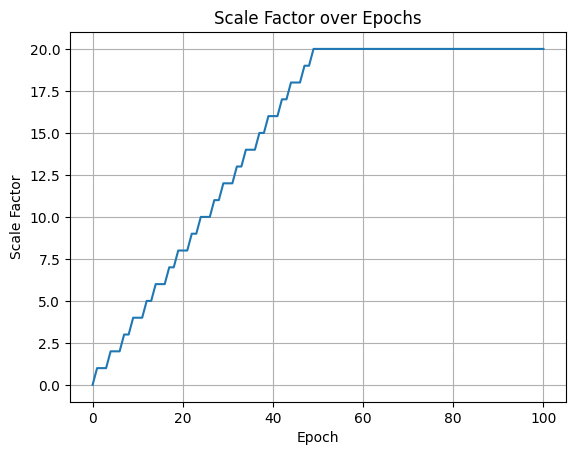

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import math

def replace_values_with_epoch1(epoch):
    if epoch == 0:
        num_values_to_replace = 0
    elif 1 <= epoch < 50:  # 49 epochs to increase from 1 to 10
        num_values_to_replace = 1 + (epoch - 1) * 9 // 48  # Linearly increase from 1 to 10 over 49 epochs
    else:
        num_values_to_replace = 10  # Keep replacing 10 values for epochs >= 50
    return num_values_to_replace

def replace_values_with_epoch2(epoch):
    if epoch == 0:
        num_values_to_replace = 0
    elif 1 <= epoch < 50:  # 49 epochs to increase from 1 to 20
        num_values_to_replace = 1 + (epoch - 1) * 19 // 48  # Linearly increase from 1 to 20 over 49 epochs
    else:
        num_values_to_replace = 20  # Keep replacing 20 values for epochs >= 50
    return num_values_to_replace


# 定义一个范围的epoch
epochs = np.arange(0, 101)  # epoch范围是0-100

# 计算每个epoch对应的放大系数
scale_factors = [replace_values_with_epoch2(epoch) for epoch in epochs]

# 绘制曲线
plt.plot(epochs, scale_factors)
plt.xlabel('Epoch')
plt.ylabel('Scale Factor')
plt.title('Scale Factor over Epochs')
plt.grid(True)
plt.show()


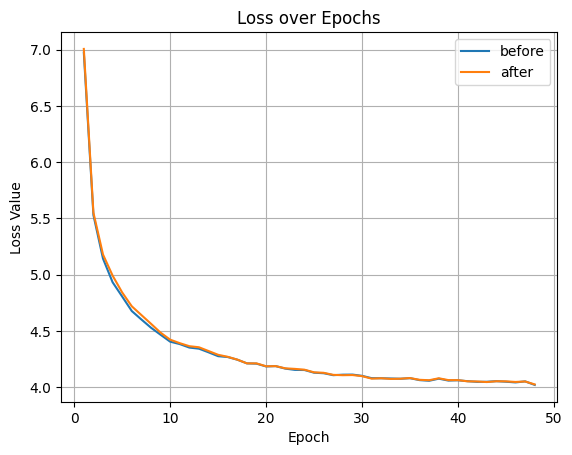

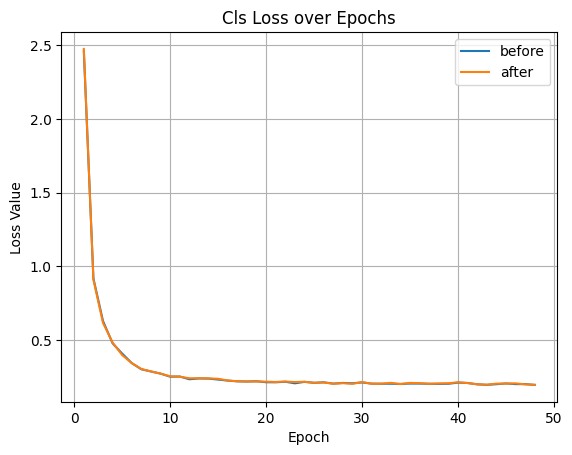

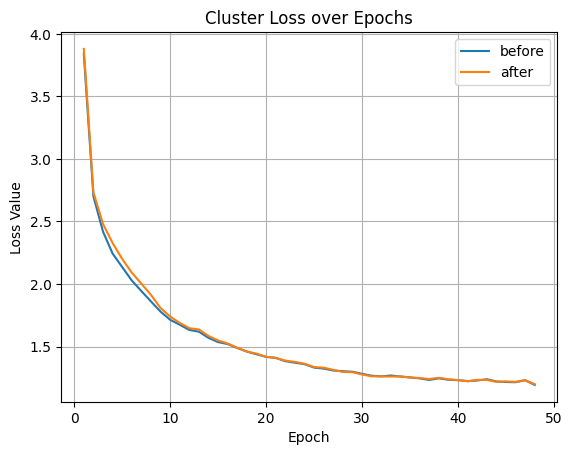

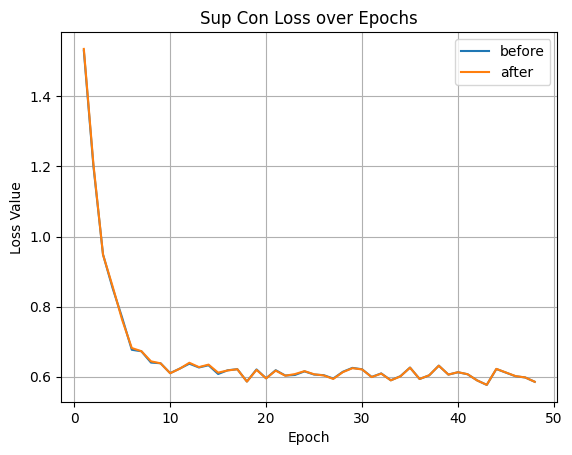

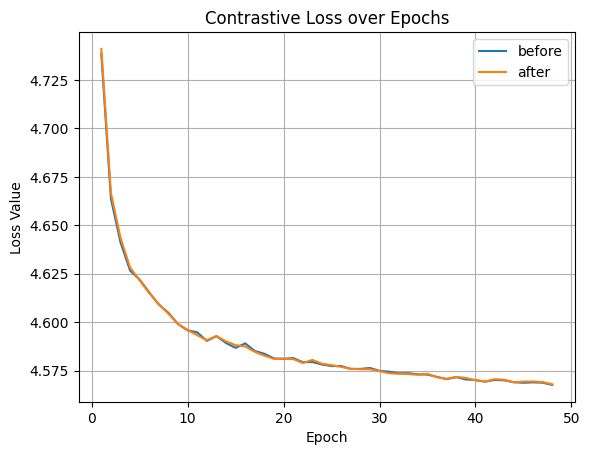

In [41]:
# 分析设备变更前后的差异
import re
import matplotlib.pyplot as plt

def extract_losses_from_log(filename):
    # 从文件中读取数据
    with open(filename, 'r') as f:
        lines = f.readlines()

    # 使用正则表达式提取loss值
    pattern = r"Epoch: \[\d+\]\[\d+/46\]\s+loss (\d+\.\d+)\s+cls_loss: (\d+\.\d+) cluster_loss: (\d+\.\d+) sup_con_loss: (\d+\.\d+) contrastive_loss: (\d+\.\d+)"
    
    # 主列表
    loss_values, cls_loss_values, cluster_loss_values, sup_con_loss_values, contrastive_loss_values = [], [], [], [], []
    
    # 临时列表
    temp_loss, temp_cls_loss, temp_cluster_loss, temp_sup_con_loss, temp_contrastive_loss = [], [], [], [], []

    for line in lines:
        match = re.search(pattern, line)
        if match:
            temp_loss.append(float(match.group(1)))
            temp_cls_loss.append(float(match.group(2)))
            temp_cluster_loss.append(float(match.group(3)))
            temp_sup_con_loss.append(float(match.group(4)))
            temp_contrastive_loss.append(float(match.group(5)))

            # 如果是最后一个batch，计算均值并添加到主列表
            if "Epoch: [" in line and "[45/46]" in line:
                loss_values.append(sum(temp_loss) / len(temp_loss))
                cls_loss_values.append(sum(temp_cls_loss) / len(temp_cls_loss))
                cluster_loss_values.append(sum(temp_cluster_loss) / len(temp_cluster_loss))
                sup_con_loss_values.append(sum(temp_sup_con_loss) / len(temp_sup_con_loss))
                contrastive_loss_values.append(sum(temp_contrastive_loss) / len(temp_contrastive_loss))
                
                # 清空临时列表
                temp_loss, temp_cls_loss, temp_cluster_loss, temp_sup_con_loss, temp_contrastive_loss = [], [], [], [], []

    return loss_values, cls_loss_values, cluster_loss_values, sup_con_loss_values, contrastive_loss_values


# 从两个日志文件中提取loss值
loss1, cls_loss1, cluster_loss1, sup_con_loss1, contrastive_loss1 = extract_losses_from_log('/wang_hp/zhy/SimGCD-main/dev_outputs/simgcd/log/Why1-removemin_(13.09.2023_|_18.487)/log.txt')
loss2, cls_loss2, cluster_loss2, sup_con_loss2, contrastive_loss2 = extract_losses_from_log('/wang_hp/zhy/SimGCD-main/dev_outputs/simgcd/log/Why??_(13.09.2023_|_51.339)/log.txt')

# 获取最小的epoch数
min_epochs = min(len(loss1), len(loss2))

# 绘制五个图
def plot_losses(losses1, losses2, title):
    epochs = list(range(1, min_epochs + 1))
    plt.plot(epochs, losses1[:min_epochs], label='before')
    plt.plot(epochs, losses2[:min_epochs], label='after')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(loss1, loss2, 'Loss over Epochs')
plot_losses(cls_loss1, cls_loss2, 'Cls Loss over Epochs')
plot_losses(cluster_loss1, cluster_loss2, 'Cluster Loss over Epochs')
plot_losses(sup_con_loss1, sup_con_loss2, 'Sup Con Loss over Epochs')
plot_losses(contrastive_loss1, contrastive_loss2, 'Contrastive Loss over Epochs')


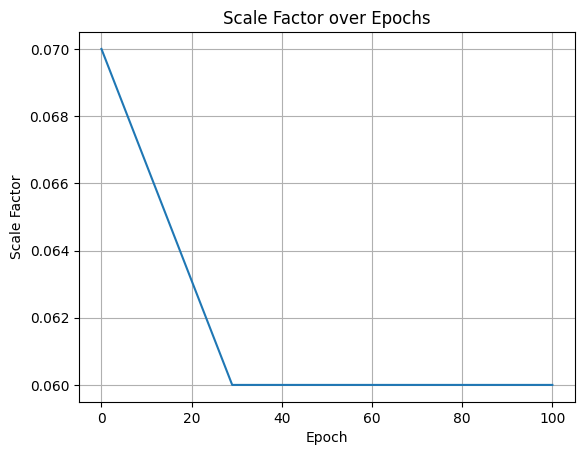

0.06862068965517241

In [188]:
# 强化novel
import numpy as np
import matplotlib.pyplot as plt
import math

def scale_factor(epoch):
    return 1 + 1 / (1 + math.exp(-(epoch-50)*0.1)) /2

def scale(epoch):
    test = np.concatenate((np.linspace(0.07,0.06, 30),np.ones(200 - 30) * 0.06))
    return test[epoch]

# 定义一个范围的epoch
epochs = np.arange(0, 101)  # epoch范围是0-100

# 计算每个epoch对应的放大系数
scale_factors = [scale(epoch) for epoch in epochs]

# 绘制曲线
plt.plot(epochs, scale_factors)
plt.xlabel('Epoch')
plt.ylabel('Scale Factor')
plt.title('Scale Factor over Epochs')
plt.grid(True)
plt.show()
scale(4)

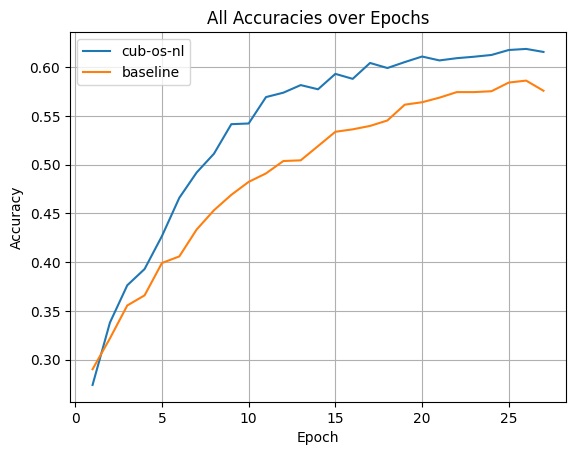

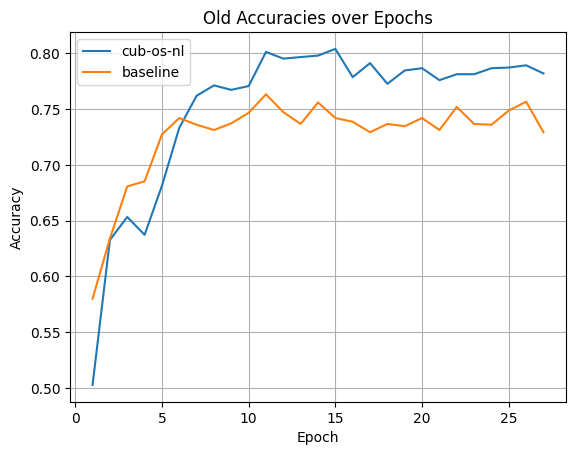

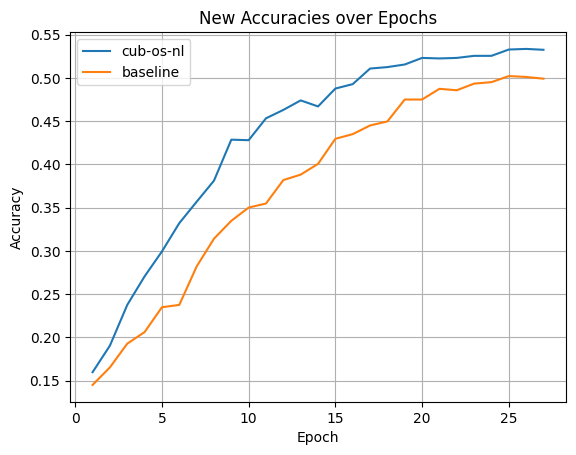

In [189]:
import re
import matplotlib.pyplot as plt

def extract_accuracies_from_log(filename):
    # 从文件中读取数据
    with open(filename, 'r') as f:
        lines = f.readlines()

    # 使用正则表达式提取精度值
    pattern = r"Train Accuracies: All (\d+\.\d+) \| Old (\d+\.\d+) \| New (\d+\.\d+)"
    all_accuracies = []
    old_accuracies = []
    new_accuracies = []

    for line in lines:
        match = re.search(pattern, line)
        if match:
            all_accuracies.append(float(match.group(1)))
            old_accuracies.append(float(match.group(2)))
            new_accuracies.append(float(match.group(3)))

    return all_accuracies, old_accuracies, new_accuracies

# 从两个日志文件中提取精度值
all_accuracies1, old_accuracies1, new_accuracies1 = extract_accuracies_from_log('/wang_hp/zhy/SimGCD-main/dev_outputs/3view/log/temp-test-cub-temp0.06-osloss_(22.09.2023_|_34.934)/log.txt')
all_accuracies2, old_accuracies2, new_accuracies2 = extract_accuracies_from_log('/wang_hp/zhy/SimGCD-main/dev_outputs/simgcd/log/Why??_(13.09.2023_|_51.339)/log.txt')

# print(np.array(all_accuracies1)-np.array(all_accuracies2))
# print(np.array(old_accuracies1)-np.array(old_accuracies2))
# print(np.array(new_accuracies1)-np.array(new_accuracies2))
# 获取最小的epoch数
min_epochs = min(len(all_accuracies1), len(all_accuracies2))

# 绘制三个图
def plot_accuracies(accuracies1, accuracies2, title):
    epochs = list(range(1, min_epochs + 1))
    plt.plot(epochs, accuracies1[:min_epochs], label='cub-os-nl')
    plt.plot(epochs, accuracies2[:min_epochs], label='baseline')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracies(all_accuracies1, all_accuracies2, 'All Accuracies over Epochs')
plot_accuracies(old_accuracies1, old_accuracies2, 'Old Accuracies over Epochs')
plot_accuracies(new_accuracies1, new_accuracies2, 'New Accuracies over Epochs')

In [1]:
# negative learning测试
import torch
import torch.nn as nn

# 创建一个简单的4x3的student_out张量
student_out = torch.tensor([[0.2, 0.4, 0.1],
                            [0.5, 0.3, 0.8],
                            [0.6, 0.4, 0.3],
                            [0.1, 0.9, 0.7]])

k = 1

# 创建一个和student_out形状相同的全零张量negative_label
negative_label = torch.zeros_like(student_out)

# 获取student_out中每一行最小的k个值所在的位置
_, indices = torch.topk(student_out, k, largest=False, dim=1)

# negative_label对应位置赋值为1
rows = torch.arange(student_out.size(0)).unsqueeze(1).repeat(1, k)
negative_label[rows, indices] = 1

# 计算交叉熵损失
loss_fn = nn.BCEWithLogitsLoss()
loss = loss_fn((1-student_out)/0.1, negative_label.float())

print("student_out:")
print(student_out)
print("negative_label:")
print(negative_label)
print("loss:", loss.item())


/opt/conda/envs/gcd/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


student_out:
tensor([[0.2000, 0.4000, 0.1000],
        [0.5000, 0.3000, 0.8000],
        [0.6000, 0.4000, 0.3000],
        [0.1000, 0.9000, 0.7000]])
negative_label:
tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.]])
loss: 2.9600837230682373


In [4]:
import torch
import torch.nn as nn

# 模拟的scale_factor函数
def scale_factor1(epoch):
    # 为了简化，我们这里直接返回一个固定的值
    return 2

def scale_factor2(epoch):
    # 同样，为了简化，我们这里直接返回一个固定的值
    return 1

# 创建一个简单的5x150的student_out张量
student_out = torch.tensor([[0.2, 0.4, 0.1, 0.5],
                            [0.5, 0.3, 0.8, 0.5],
                            [0.6, 0.4, 0.3, 0.5],
                            [0.1, 0.9, 0.7, 0.5]])
epoch = 1  # 假设当前是第一个epoch

_, max_indices = torch.max(student_out, dim=1)

# 创建一个和student_out形状相同的全零张量negative_label
negative_label = torch.zeros_like(student_out)

# 根据每一行的最大值所在位置来动态地确定k，并获取每一行的最小k个值的索引
for i, max_index in enumerate(max_indices):
    if max_index < 2:
        k = scale_factor1(epoch)
    else:
        k = scale_factor2(epoch)
    
    _, min_indices = torch.topk(student_out[i], k, largest=False)
    negative_label[i, min_indices] = 1

# 计算交叉熵损失
loss_fn = nn.BCEWithLogitsLoss()
loss = loss_fn((1-student_out)/0.1, negative_label.float())

print("student_out:")
print(student_out)
print("negative_label:")
print(negative_label)
print("loss:", loss.item())


student_out:
tensor([[0.2000, 0.4000, 0.1000, 0.5000],
        [0.5000, 0.3000, 0.8000, 0.5000],
        [0.6000, 0.4000, 0.3000, 0.5000],
        [0.1000, 0.9000, 0.7000, 0.5000]])
negative_label:
tensor([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 1., 0.],
        [1., 0., 0., 1.]])
loss: 2.7842414379119873


In [9]:
import torch
import torch.nn as nn

# 模拟的scale_factor函数
def scale_factor1(epoch):
    return 2

def scale_factor2(epoch):
    return 1

# 创建一个简单的5x150的student_out张量
student_out = torch.tensor([[0.2, 0.4, 0.1, 0.5],
                            [0.5, 0.3, 0.8, 0.5],
                            [0.6, 0.4, 0.3, 0.5],
                            [0.1, 0.9, 0.7, 0.5]])
epoch = 1

_, max_indices = torch.max(student_out, dim=1)

# 创建一个和student_out形状相同的全零张量negative_label和一个全False的mask张量
# negative_label = torch.zeros_like(student_out)
mask = torch.zeros_like(student_out, dtype=torch.bool)

for i, max_index in enumerate(max_indices):
    if max_index < 100:
        k = scale_factor1(epoch)
    else:
        k = scale_factor2(epoch)
    
    _, min_indices = torch.topk(student_out[i], k, largest=False)
    # negative_label[i, min_indices] = 1
    mask[i, min_indices] = True

# 筛选出student_out中mask为True的元素并进行运算
selected_elements = (1 - student_out)[mask] / 0.1

print("student_out:")
print(student_out)
print("negative_label:")
print(negative_label)
print("mask:")
print(mask)
print("selected_elements:")
print(selected_elements)

# 这里计算损失的方法需要调整，因为筛选后的selected_elements的维度已经发生了变化
# 一个可能的方法是将negative_label的对应位置也筛选出来进行损失计算
loss_fn = nn.BCEWithLogitsLoss()
loss = loss_fn(selected_elements, torch.ones_like(selected_elements).float())
print("loss:", loss.item())


student_out:
tensor([[0.2000, 0.4000, 0.1000, 0.5000],
        [0.5000, 0.3000, 0.8000, 0.5000],
        [0.6000, 0.4000, 0.3000, 0.5000],
        [0.1000, 0.9000, 0.7000, 0.5000]])
negative_label:
tensor([[1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [0., 1., 1., 0.],
        [1., 0., 0., 1.]])
mask:
tensor([[ True, False,  True, False],
        [False,  True, False,  True],
        [False,  True,  True, False],
        [ True, False, False,  True]])
selected_elements:
tensor([8., 9., 7., 5., 6., 7., 9., 5.])
loss: 0.0022889161482453346


In [6]:
negative_label[mask]

tensor([1., 1., 1., 1., 1., 1., 1., 1.])

In [5]:
import torch
teacher_out = torch.tensor([[0.9,0.05,0.04,0.01],[0.01,0.05,0.4,0.01],[0.01,0.05,0.4,0.01]])
# 获取teacher_out中每行的最大值及其位置索引
max_values, max_indices = torch.max(teacher_out, dim=-1)

# 根据max_indices的位置创建一个阈值张量
thresholds = torch.where(max_indices < 2, torch.tensor(0.7), torch.tensor(0.35))
thresholds = thresholds.to(teacher_out.device)  # 确保阈值张量在与teacher_out相同的设备上

# 使用teacher_out的最大值和相应的阈值进行比较
mask = max_values.ge(thresholds).float()

# 如果需要，分割mask
# mask = mask.chunk(2)
mask


tensor([1., 1., 1.])